In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
)
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ]
)
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = (
    32  # this is lower than the ViT paper but it's because we're starting small
)

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,  # use manually created transforms
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e3dbc6ebe00>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

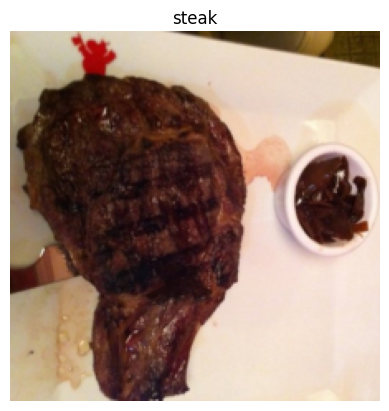

In [9]:
plt.imshow(
    image.permute(1, 2, 0)
)  # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [10]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)

In [11]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(embedding_layer_input_shape)
print(embedding_layer_output_shape)

(224, 224, 3)
(196, 768)


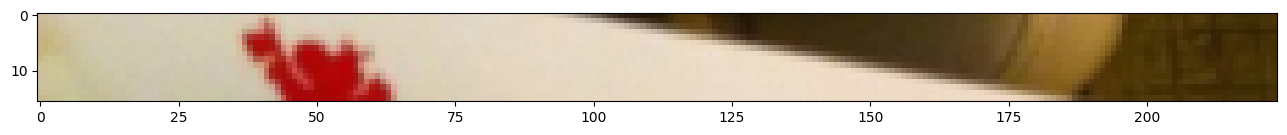

In [12]:
image_permuted = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:16, :, :])

In [13]:
def patchifying(img):
    img_size = 224
    patch_size = 16
    image_permuted = img.permute(1, 2, 0)

    fig, axs = plt.subplots(
        nrows=img_size // patch_size,
        ncols=img_size // patch_size,
        sharex=True,
        sharey=True,
    )

    counter = 0
    next_patch_size_length = patch_size
    while next_patch_size_length <= image_permuted.shape[0]:
        next_patch_size_width = patch_size
        while next_patch_size_width <= image_permuted.shape[1]:
            ax = axs.flat[counter]
            ax.imshow(
                image_permuted[
                    next_patch_size_length - patch_size:next_patch_size_length,
                    next_patch_size_width - patch_size:next_patch_size_width,
                    :,
                ]
            )
            ax.set_xlabel(counter + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            next_patch_size_width += patch_size
            counter += 1
        next_patch_size_length += patch_size


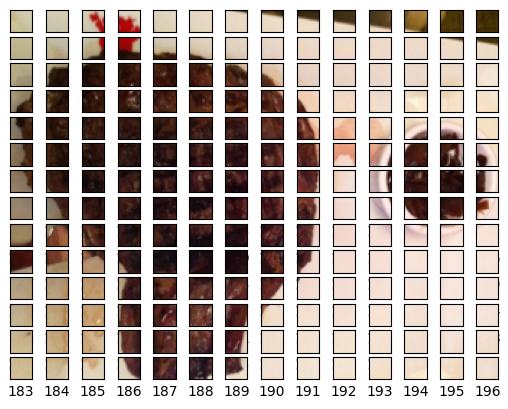

In [14]:
patchifying(image)

In [15]:
class Patchifier(nn.Module):
    def __init__(self, channel_size=3, patch_size=16, img_size=224, embed_dim=768) -> None:
        super().__init__()

        self.patch_size = patch_size
        self.image_size = img_size
        self.channel_size = channel_size
        self.embed_dim = embed_dim

        self.conv = nn.Conv2d(
            in_channels=channel_size,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
        self.flattening = nn.Flatten(2)
        self.linear = nn.Linear(
            in_features=embed_dim,
            out_features=embed_dim,
        )

    def forward(self, x):
        b, c, h, w = x.shape
        assert c == self.channel_size, f"Expected {self.channel_size} channels, got {c}"
        assert h % self.patch_size == 0 and w % self.patch_size == 0, "Image size not divisible by patch size"

        patches = self.conv(x)  # [B, embed_dim, H/patch, W/patch]
        patches = self.flattening(patches).transpose(1, 2)  # [B, num_patches, embed_dim]
        patches = self.linear(patches)
        return patches

In [16]:
model = Patchifier()
model(image.unsqueeze(0))

tensor([[[ 0.2409, -0.0232,  0.0577,  ..., -0.0868, -0.1976,  0.1384],
         [ 0.2570, -0.0446,  0.0567,  ..., -0.1054, -0.2247,  0.1352],
         [ 0.2127, -0.0676,  0.1543,  ..., -0.0963, -0.0504,  0.2412],
         ...,
         [ 0.2897, -0.0597,  0.0701,  ..., -0.1269, -0.2601,  0.1597],
         [ 0.2892, -0.0668,  0.0754,  ..., -0.1101, -0.2362,  0.1626],
         [ 0.2883, -0.0654,  0.0563,  ..., -0.1265, -0.2491,  0.1500]]],
       grad_fn=<AddBackward0>)